In [ ]:
library (Seurat)

library (dplyr)
library(ggplot2)
library(patchwork) # for arranging plots

library (viridisLite)
library (RColorBrewer)

#library (ggrastr)

In [ ]:
display.brewer.all()

# Cela affichera toutes les palettes de couleurs disponibles dans RColorBrewer. Les palettes sont divisées en trois catégories :
# 	•	Qualitative : pour des variables catégorielles (par exemple, Set1, Paired, Dark2, etc.).
# 	•	Sequential : pour des données ordonnées ou continues (par exemple, Blues, Reds, YlGnBu, etc.).
# 	•	Diverging : pour des données qui vont d’un extrême à un autre (par exemple, BrBG, RdBu, PiYG, etc.).

dans l'article : 

“Processing of B. subtilis data from the growth in rich media experiment Clustering and data analysis for the combined 10 samples of B. subtilis grown in rich medium was performed using Scanpy (59) and verified with Seurat v3 (61) and UNCURL (62). Experiment 1 sampled OD points 0.5, 1.0, 1.7, 2.0, 2.8, and 3.2, whereas in experiment 2, we collected OD points 0.5, 1.0, 1.3, 1.7, 2.8, 3.5, 5.3, and 6.0. For the data from both experiments separately, we discarded any transcriptomes that had a number of total reads fewer than 200. Then, we filtered the data and retained only reads representing the mRNA counts (excluding the ribosomal and tRNA reads). Finally, we combined the data matrices together. Because the read depth decreased for the higher OD samples (fig. S26), for selecting the highest quality data, we implemented differential thresholds for each OD in the combined matrix, retaining the top 75% of the cells by read counts for each OD sample. This resulted in retention of 25,214 transcriptomes from both experiments. Finally, we performed batch correction through Scanpy, using a python implementation of ComBat (63, 64). Cells that passed the QC were clustered using a pipeline described in previous studies (7, 60).” ([Kuchina et al., 2021, p. 8])



Le pipeline de traitement des données de Bacillus subtilis dans l’expérience de croissance en milieu riche, tel que décrit par Kuchina et al. (2021), suit plusieurs étapes clés de filtrage et d’analyse :

⸻

1. Acquisition des échantillons

Les auteurs ont réalisé deux expériences indépendantes, chacune avec des mesures d’OD (densité optique) à différentes phases de croissance :
	•	Expérience 1 : OD = 0.5, 1.0, 1.7, 2.0, 2.8, 3.2
	•	Expérience 2 : OD = 0.5, 1.0, 1.3, 1.7, 2.8, 3.5, 5.3, 6.0

Cela signifie qu’ils ont échantillonné les bactéries à différents stades de croissance pour capturer les changements transcriptionnels.

⸻

2. Filtrage des cellules et des reads

Avant d’analyser les données, plusieurs filtres ont été appliqués :

a) Seuil de reads total
	•	Les transcriptomes avec moins de 200 reads au total ont été exclus.
👉 Cela permet d’éliminer les cellules de mauvaise qualité avec une couverture trop faible.

b) Sélection des reads d’intérêt
	•	Seuls les reads représentant des ARNm ont été conservés.
	•	Les reads de l’ARN ribosomal (rRNA) et de l’ARN de transfert (tRNA) ont été exclus.
👉 Cette étape est cruciale, car les ARN non codants peuvent dominer les séquences brutes et fausser l’analyse.

c) Normalisation de la profondeur de lecture (read depth)
	•	Ils ont remarqué que la profondeur de lecture diminue aux ODs élevées (Figure S26).
	•	Pour garantir une qualité uniforme des données, ils ont appliqué des seuils différenciés en fonction des OD.
	•	Seules les 75% des cellules ayant le plus de reads ont été conservées pour chaque OD.
👉 Cela garantit que seules les cellules les mieux séquencées sont utilisées.

d) Fusion des matrices
	•	Une fois les données filtrées, les matrices des deux expériences ont été combinées.

⸻

3. Correction de batch et clustering
	•	Une correction de batch a été appliquée avec Scanpy, en utilisant ComBat (implémentation en Python).
👉 Cela corrige les effets de lot pour rendre les données comparables entre les expériences.
	•	Clustering des cellules :
	•	Utilisation de Scanpy (outil principal).
	•	Vérification des clusters avec Seurat v3 et UNCURL.
	•	Application d’un pipeline de clustering basé sur des études précédentes.

⸻

Résumé du pipeline
	1.	Échantillonnage à différentes OD dans deux expériences.
	2.	Filtrage des cellules (seuil de 200 reads).
	3.	Élimination des ARN ribosomaux et de transfert.
	4.	Normalisation en conservant les 75% des meilleures cellules par OD.
	5.	Fusion des matrices de données des deux expériences.
	6.	Correction de batch avec ComBat (Scanpy).
	7.	Clustering avec Scanpy, Seurat et UNCURL.

⸻

👉 Pourquoi ce pipeline ?
L’objectif est de garantir une analyse robuste des transcriptomes bactériens en supprimant les biais liés aux différences de qualité des cellules et des expériences.

j'ai utilisé leur script modifie pour mettre un threshold de 0 pour conserver l'ensembles des counts  : dans l'autre article les auteurs utilise un filtre avec un threshold pour ne garder que les meilleurs 
de plus je filtre les mRNA dès le debut avec cette fonction 

ici : j'ai deja combiné les resultats de sequençages des 2 repetitions de l'expérience en un seul objet seurat : rep1 et rep2 
avec Seurat V5 c'est possible de combiner les objets seurat de 2 expériences differentes en un seul objet seurat pout faire des analyses en commun 

 

In [57]:
# Import the data de données mRNAs non filtrées
# load the Seurat object
path_RNA_combined  <- "7_Article/results/tab_seurat_correct/RNA_combined.rds"
RNA_combined <- readRDS(path_RNA_combined)
seurat_obj <- RNA_combined

In [58]:
seurat_obj

An object of class Seurat 
4422 features across 730249 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

730249 samples 
Cela signifie qu'il  y a 730249 cellules potentielles dans l'objet seurat_obj 
On aura besoin de filtre pour identifier les "vrai cellules"

In [45]:
str (seurat_obj)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 2
  .. .. .. .. ..$ counts.1:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:2034849] 4110 70 2747 1635 1759 1838 2420 3003 161 675 ...
  .. .. .. .. .. .. ..@ p       : int [1:300075] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 4422 300074
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:2034849] 0.111 0.167 2 0.333 0.333 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ counts.2:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:11781869] 617 845 848 1346 2735 2819 2825 2924 3200 4020 ...
  .. .. .. .. .. .. ..@ p       : int [1:430176] 0 0 12 12 12 64 72 73

In [46]:
#head (seurat_obj)
#tail (seurat_obj)
View(seurat_obj@meta.data)

,nCount_RNA,nFeature_RNA,rep,sublibrary,well,cond
,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
rep1_AAACATCG_AACCGAGA_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AACGCTTA_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AACTCACC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AATCCGTC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_ACAGATTC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AGCACCTC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AGCAGGAA_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AGCCATGC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AGGCTAAC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5


In [47]:
Assays(RNA_combined)  # Pour voir les assays disponibles

[1] "RNA"

In [48]:
Layers(RNA_combined) # check the layers

[1] "counts.1" "counts.2"

In [59]:
print ("ncount RNA : ")
summary(seurat_obj$nCount_RNA)  # Statistiques de nCount_RNA
print ("nfeature RNA : ")
summary(seurat_obj$nFeature_RNA)  # Statistiques de nFeature_RNA

[1] "ncount RNA : "


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.000     0.250     2.000    20.795     6.167 14420.359 

[1] "nfeature RNA : "


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    4.00   18.92   12.00 2615.00 

Il y a beaucoup de cellules avec 0 counts, il faut les filtrer 
on ne peut meme pas faire de graph car trop de points et surtout beaucoup de 0 

# fait un filtre sur les cellules 
🛠 Explication :
	•	subset = nCount_RNA >= 200 → Garde uniquement les cellules où le total des reads (UMIs) est supérieur ou égal à 200.
	•	subset() est la fonction recommandée pour filtrer les objets Seurat.

In [60]:
subset(seurat_obj, subset = nCount_RNA >= 200) # permet de voir rapidement les resultats du subset

seurat_obj_f <- subset(seurat_obj, subset = nCount_RNA >= 200)  # Filtrer les cellules avec un nombre de gènes exprimés >= 200    
#Filtering cells based on number of UMIs by cell


seurat_obj_f
print ("ncount RNA : ")
summary(seurat_obj_f$nCount_RNA)  # Statistiques de nCount_RNA
print ("nfeature RNA : ")
summary(seurat_obj_f$nFeature_RNA)  # Statistiques de nFeature_RNA


An object of class Seurat 
4422 features across 14963 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

An object of class Seurat 
4422 features across 14963 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

[1] "ncount RNA : "


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  200.1   297.1   462.3   693.8   812.2 14420.4 

[1] "nfeature RNA : "


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  130.0   253.0   353.0   438.3   533.0  2615.0 

In [ ]:
# 4422 features across 14963 samples 
#avec ce simple filtre on ne garde plus que 14963 cellules potentielles
# 4422 sont les gènes exprimés dans ces cellules

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


[[1]]

[[2]]


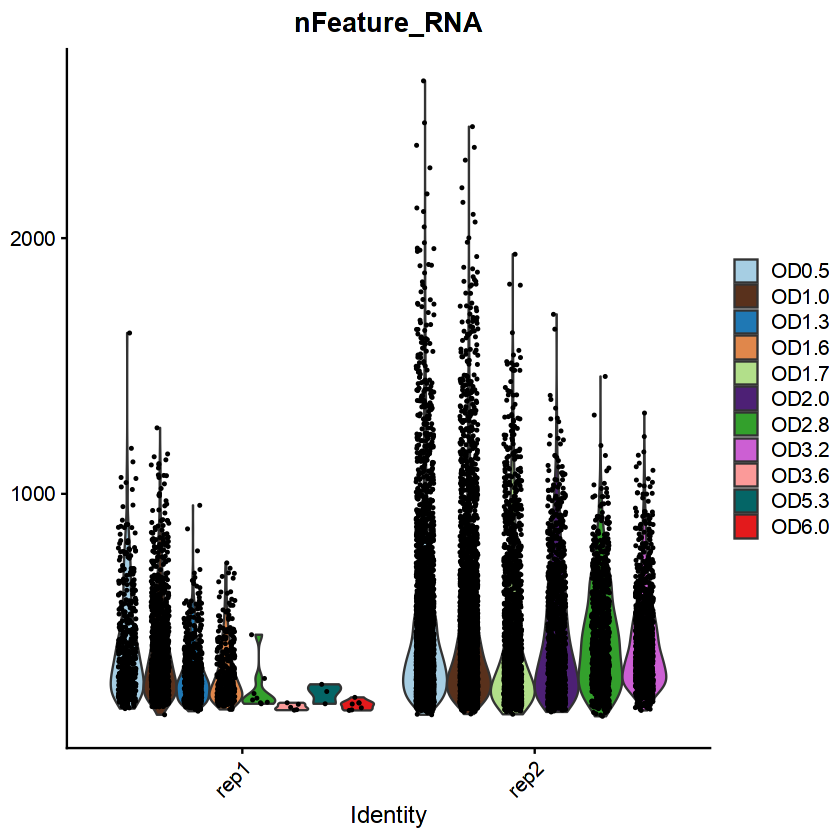

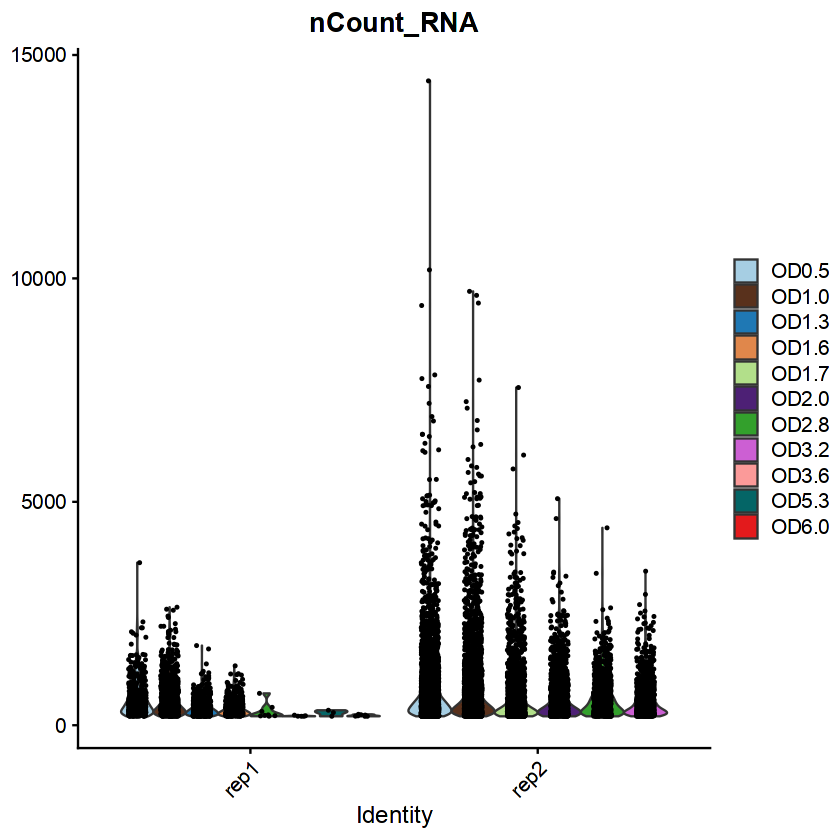

In [61]:

VlnPlot(
  object = seurat_obj_f,             # Objet Seurat contenant les données à analyser
  features =c("nFeature_RNA", "nCount_RNA"),           # Les caractéristiques à afficher (par exemple, l'expression génique, les scores PC, etc.)
  cols = brewer.pal(8, "Paired"),        # Couleurs à utiliser pour l'affichage
  pt.size = NULL,     # Taille des points (pour les points individuels)
  alpha = 1,          # Transparence des points (valeur entre 0 et 1)
  idents = NULL,      # Classes à inclure dans le graphique (par défaut, toutes les classes sont affichées)
  sort = FALSE,       # Tri des classes d'identité sur l'axe des X selon l'expression moyenne de l'attribut
  assay = NULL,       # Nom de l'assai à utiliser (par défaut, l'assai actif)
  group.by = "rep",    # Groupe (ou couleur) des cellules selon une variable (ex : identifiant d'échantillon)
  split.by = "cond",    # Facteur dans les métadonnées de l'objet pour diviser l'affichage (ex : identité de cellule)
  adjust = 1,         # Paramètre d'ajustement pour la fonction `geom_violin`
  y.max = NULL,       # Valeur maximale de l'axe des Y
  same.y.lims = FALSE, # Appliquer les mêmes limites d'axe Y pour toutes les cellules
  log = FALSE,        # Appliquer une échelle logarithmique à l'axe des Y
  ncol = 2,        # Nombre de colonnes à afficher si plusieurs graphiques sont combinés
 #
  layer = NULL,       # Couche des données à afficher (ex : "counts" ou "data")
  split.plot = FALSE, # Diviser les violons en plusieurs formes pour chaque groupe
  stack = FALSE,      # Empiler les graphiques pour chaque caractéristique sur l'axe X
  combine = FALSE,     # Combiner les graphiques en un seul objet ggplot (FALSE pour une liste de ggplots séparés)
  fill.by = "feature",# Remplir les violons selon la caractéristique ou l'identité
  flip = FALSE,       # Inverser l'orientation du graphique (identités sur l'axe des X)
  add.noise = TRUE,   # Ajouter un petit bruit pour la visualisation des points
  raster = NULL       # Convertir les points en format raster (nécessite l'installation de 'ggrastr')
)

probleme d'affichage pour les couleurs :  lié au nombre de categories trop importantes par rapport au nombre de couleurs disponibles dans la palette , donc la fonction ne va pas afficher la palette souhaité

on remarque que plus la DO est importante plus la profondeur de sequençage est faible (on detecte moins de genes et moins de reads (UMIs))

de plus on remarque que cette profondeur de sequençage est plus importante pour la rep2 
les DO les plus elevés de la rep1 possèdent des profondeurs de sequençage plus faibles qui ne sont probablement pas suffisantes pour une analyse de single cell RNA seq , je vais decider de les retirer

In [ ]:

# An object of class Seurat 
# 4422 features across 14963 samples within 1 assay 
# Active assay: RNA (4422 features, 0 variable features)
#  2 layers present: counts.1, counts.2
# [1] "ncount RNA : "
#    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#   200.1   297.1   462.3   693.8   812.2 14420.4 
# [1] "nfeature RNA : "
#    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#   130.0   253.0   353.0   438.3   533.0  2615.0 

#130 gènes exprimés au minimum par cellule
#2615 gènes exprimés au maximum par cellule
#200 UMIs au minimum par cellule
#14420 UMIs au maximum par cellule

subset(seurat_obj_f, 
    subset = 
        nFeature_RNA > 200 # au moins 200 gènes exprimés par cellule
        #& nFeature_RNA < 6000 # au max 6000 gènes exprimés par cellule ( de toute façon, on a max 2615 gènes detectés au max dans une cellule unique) et on possède 4422 gènes ARNm (4422 features) donc on ne peut pas avoir plus de 4422 gènes exprimés par cellule
        & nCount_RNA > 200  # au moins 200 UMIs par cellule
        & nCount_RNA < 10000 # au max 10000 UMIs par cellule
        )
        # Filtrer les cellules avec un nombre de gènes exprimés entre 200 et 6000 et un nombre d'UMIs entre 800 et 20000

seurat_obj_f2 <- subset(seurat_obj_f, subset = nFeature_RNA > 200 & nFeature_RNA < 6000 & nCount_RNA > 200 & nCount_RNA < 20000) # Filtrer les cellules avec un nombre de gènes exprimés entre 200 et 6000 et un nombre d'UMIs entre 800 et 20000

An object of class Seurat 
4422 features across 3817 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

4422 features across 3817 samples

je ne garde plus que 

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


[[1]]

[[2]]


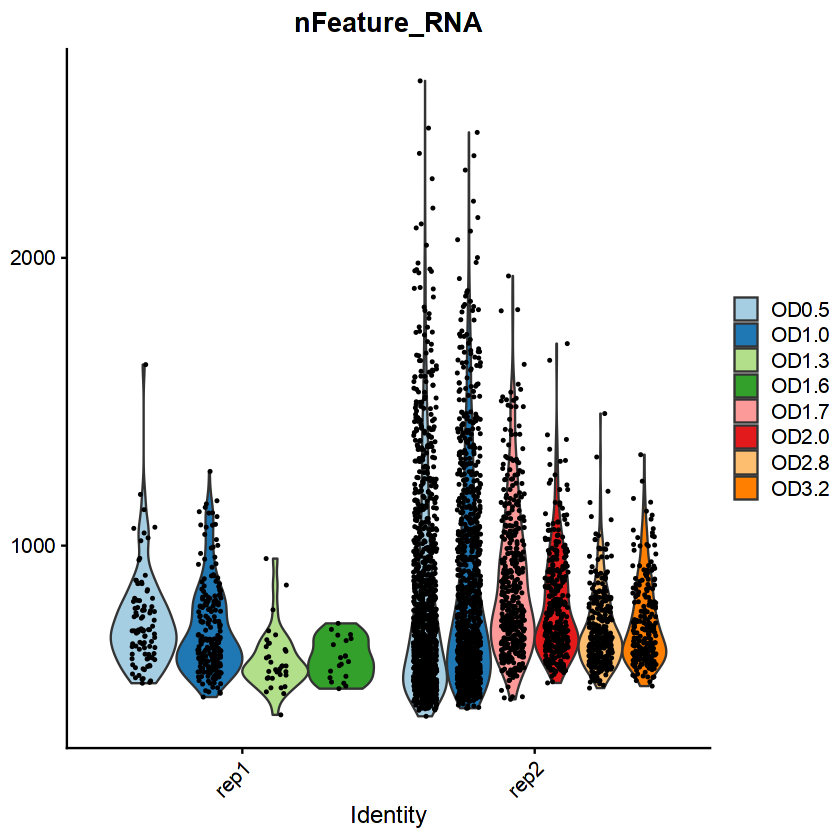

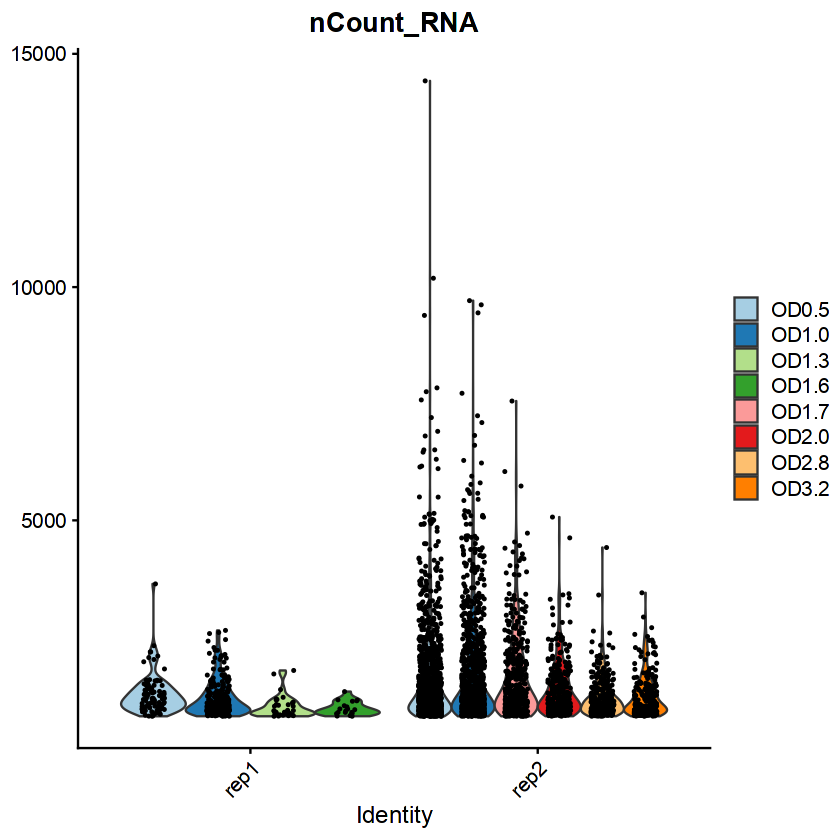

In [54]:

VlnPlot(
  object = seurat_obj,             # Objet Seurat contenant les données à analyser
  features =c("nFeature_RNA", "nCount_RNA"),           # Les caractéristiques à afficher (par exemple, l'expression génique, les scores PC, etc.)
  cols = brewer.pal(8, "Paired"),        # Couleurs à utiliser pour l'affichage
  pt.size = NULL,     # Taille des points (pour les points individuels)
  alpha = 1,          # Transparence des points (valeur entre 0 et 1)
  idents = NULL,      # Classes à inclure dans le graphique (par défaut, toutes les classes sont affichées)
  sort = FALSE,       # Tri des classes d'identité sur l'axe des X selon l'expression moyenne de l'attribut
  assay = NULL,       # Nom de l'assai à utiliser (par défaut, l'assai actif)
  group.by = "rep",    # Groupe (ou couleur) des cellules selon une variable (ex : identifiant d'échantillon)
  split.by = "cond",    # Facteur dans les métadonnées de l'objet pour diviser l'affichage (ex : identité de cellule)
  adjust = 1,         # Paramètre d'ajustement pour la fonction `geom_violin`
  y.max = NULL,       # Valeur maximale de l'axe des Y
  same.y.lims = FALSE, # Appliquer les mêmes limites d'axe Y pour toutes les cellules
  log = FALSE,        # Appliquer une échelle logarithmique à l'axe des Y
  ncol = 2,        # Nombre de colonnes à afficher si plusieurs graphiques sont combinés
 #
  layer = NULL,       # Couche des données à afficher (ex : "counts" ou "data")
  split.plot = FALSE, # Diviser les violons en plusieurs formes pour chaque groupe
  stack = FALSE,      # Empiler les graphiques pour chaque caractéristique sur l'axe X
  combine = FALSE,     # Combiner les graphiques en un seul objet ggplot (FALSE pour une liste de ggplots séparés)
  fill.by = "feature",# Remplir les violons selon la caractéristique ou l'identité
  flip = FALSE,       # Inverser l'orientation du graphique (identités sur l'axe des X)
  add.noise = TRUE,   # Ajouter un petit bruit pour la visualisation des points
  raster = NULL       # Convertir les points en format raster (nécessite l'installation de 'ggrastr')
)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“'ncol' is ignored with 'stack' is TRUE”


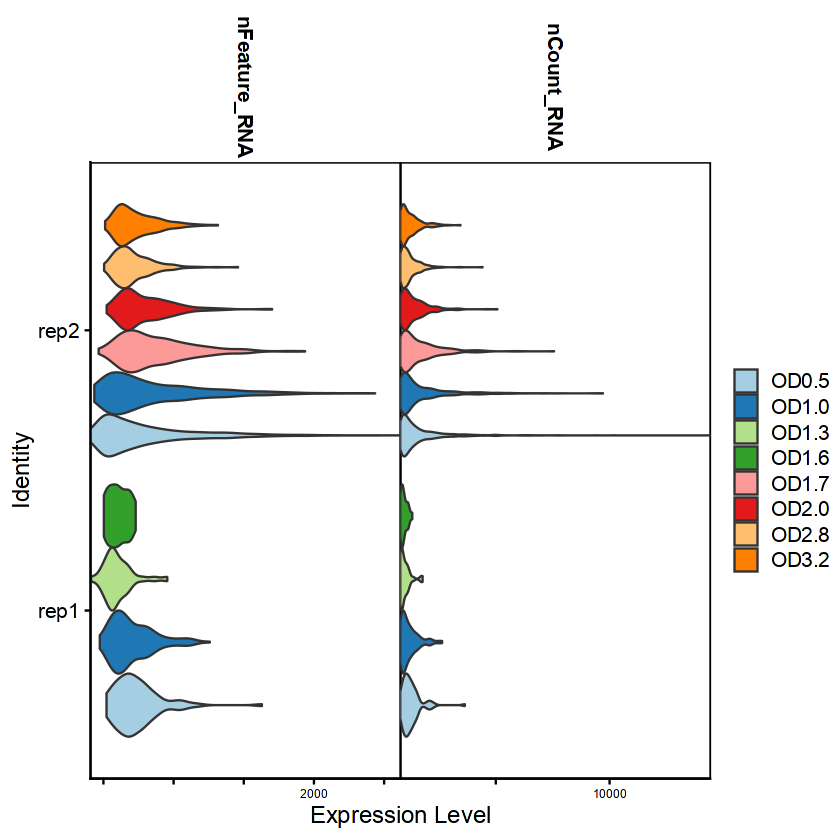

In [55]:

VlnPlot(
  object = seurat_obj,             # Objet Seurat contenant les données à analyser
  features =c("nFeature_RNA", "nCount_RNA"),           # Les caractéristiques à afficher (par exemple, l'expression génique, les scores PC, etc.)
  cols = brewer.pal(8, "Paired"),        # Couleurs à utiliser pour l'affichage
  pt.size = NULL,     # Taille des points (pour les points individuels)
  alpha = 1,          # Transparence des points (valeur entre 0 et 1)
  idents = NULL,      # Classes à inclure dans le graphique (par défaut, toutes les classes sont affichées)
  sort = FALSE,       # Tri des classes d'identité sur l'axe des X selon l'expression moyenne de l'attribut
  assay = NULL,       # Nom de l'assai à utiliser (par défaut, l'assai actif)
  group.by = "rep",    # Groupe (ou couleur) des cellules selon une variable (ex : identifiant d'échantillon)
  split.by = "cond",    # Facteur dans les métadonnées de l'objet pour diviser l'affichage (ex : identité de cellule)
  adjust = 1,         # Paramètre d'ajustement pour la fonction `geom_violin`
  y.max = NULL,       # Valeur maximale de l'axe des Y
  same.y.lims = FALSE, # Appliquer les mêmes limites d'axe Y pour toutes les cellules
  log = FALSE,        # Appliquer une échelle logarithmique à l'axe des Y
  ncol = 2,        # Nombre de colonnes à afficher si plusieurs graphiques sont combinés
 #
  layer = NULL,       # Couche des données à afficher (ex : "counts" ou "data")
  split.plot = FALSE, # Diviser les violons en plusieurs formes pour chaque groupe
  stack = TRUE,      # Empiler les graphiques pour chaque caractéristique sur l'axe X
  combine = FALSE,     # Combiner les graphiques en un seul objet ggplot (FALSE pour une liste de ggplots séparés)
  fill.by = "feature",# Remplir les violons selon la caractéristique ou l'identité
  flip = FALSE,       # Inverser l'orientation du graphique (identités sur l'axe des X)
  add.noise = TRUE,   # Ajouter un petit bruit pour la visualisation des points
  raster = FALSE       # Convertir les points en format raster (nécessite l'installation de 'ggrastr')
)

# Ce code génère un graphique en violon avec les caractéristiques spécifiées. Il permet de visualiser la distribution de l’expression d’un ou plusieurs gènes (ou d’autres mesures) pour différentes classes de cellules dans un objet Seurat, avec des options de personnalisation telles que la couleur, le tri des classes, l’ajustement des axes, etc.